# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [3]:
import pandas as pd
import numpy as np

In [4]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", na_values='?')

print('Number of samples before removing nan-values: ' + str(data.shape[0]))

# Remove samples with nan-values
data.dropna(inplace=True)
print('Number of samples after removing nan-values: ' + str(data.shape[0]))

data['salary'] = data['salary'].apply(lambda x: x.strip('.')) # Remove trailing dot from salary column

data.head()

Number of samples before removing nan-values: 48842
Number of samples after removing nan-values: 45222


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

In [5]:
cats = ['education', 'marital-status', 'occupation']  # Categorical features
nums = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']  # Numerical features

steps = [
    ('cat', OneHotEncoder(), cats), # One-hot encoding for the categoricals
    ('num', StandardScaler(), nums) # Standard scaling for the numericals
]

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(data['salary']).astype(int)

# show the correlation between different features including target variable
def visualize(data, ct):
    X = ct.fit_transform(data)
    X = pd.DataFrame(X)
    X['salary'] = y

    plt.matshow(X.corr())
    plt.colorbar()
    plt.show()

# Apply your model to feature array X and labels y
def apply_model(model, X, y, random_state=66):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline, random_state)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline, random_state=66):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    # Fit the model to the training data
    pipeline.fit(X_train, y_train)
    # Predict the labels of the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# visualize(data, ct)

# Tree 
print("Tree score:", apply_model(DecisionTreeClassifier(), data, y))

# Random forest
# print("Random Forest score:", apply_model(RandomForestClassifier(), data, y))

# SVC
# print("SVC score:", apply_model(SVC(), data, y))

# K - nearest neighbours
# print("K nearest score:", apply_model(KNeighborsClassifier(), data, y))

Tree score: 0.8044223327805418


### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [6]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = y.copy()
    # Flip fraction*len(data) of the labels in copy
    for i in np.random.choice(range(len(copy)), int(fraction*len(copy)), replace=False):
        copy[i] = 1 - copy[i]
    return copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [18]:
# Code
tree_scores = []
rf_scores = []
svc_scores = []
knn_scores = []

# Random states for reproducibility
random_states = [1, 2, 3, 4, 5]

for i in np.arange(0, 0.6, 0.1):
    print("***Pertubation: " + str(i) + "***")
    y_pertubation = pertubate(y, i)
    
    tree_score = []
    rf_score = []
    svc_score = []
    knn_score = []

    # Run the models 5 times
    for j in range(5):
        tree_score.append(apply_model(DecisionTreeClassifier(), data, y_pertubation, random_states[j]))
        rf_score.append(apply_model(RandomForestClassifier(), data, y_pertubation, random_states[j]))
        svc_score.append(apply_model(SVC(), data, y_pertubation, random_states[j]))
        knn_score.append(apply_model(KNeighborsClassifier(), data, y_pertubation, random_states[j]))

    tree_scores.append(tree_score)
    rf_scores.append(rf_score)
    svc_scores.append(svc_score)
    knn_scores.append(knn_score)
    print(f"Tree score mean: {np.mean(tree_score):.2f}" + f" ,std: {np.std(tree_score):.2f}")
    print(f"Random Forest score mean: {np.mean(rf_score):.2f}" + f" ,std: {np.std(rf_score):.2f}")
    print(f"SVC score mean: {np.mean(svc_score):.2f}" + f" ,std: {np.std(svc_score):.2f}")
    print(f"K nearest score mean: {np.mean(knn_score):.2f}" + f" ,std: {np.std(knn_score):.2f}")

***Pertubation: 0.0***
Tree score mean: 0.81 ,std: 0.00
Random Forest score mean: 0.84 ,std: 0.00
SVC score mean: 0.85 ,std: 0.00
K nearest score mean: 0.83 ,std: 0.00
***Pertubation: 0.1***
Tree score mean: 0.69 ,std: 0.00
Random Forest score mean: 0.76 ,std: 0.00
SVC score mean: 0.78 ,std: 0.00
K nearest score mean: 0.75 ,std: 0.00
***Pertubation: 0.2***
Tree score mean: 0.61 ,std: 0.00
Random Forest score mean: 0.67 ,std: 0.00
SVC score mean: 0.71 ,std: 0.00
K nearest score mean: 0.66 ,std: 0.00
***Pertubation: 0.30000000000000004***
Tree score mean: 0.55 ,std: 0.00
Random Forest score mean: 0.59 ,std: 0.00
SVC score mean: 0.63 ,std: 0.00
K nearest score mean: 0.57 ,std: 0.00
***Pertubation: 0.4***
Tree score mean: 0.51 ,std: 0.01
Random Forest score mean: 0.52 ,std: 0.00
SVC score mean: 0.57 ,std: 0.00
K nearest score mean: 0.52 ,std: 0.01
***Pertubation: 0.5***
Tree score mean: 0.50 ,std: 0.00
Random Forest score mean: 0.50 ,std: 0.00
SVC score mean: 0.50 ,std: 0.00
K nearest scor

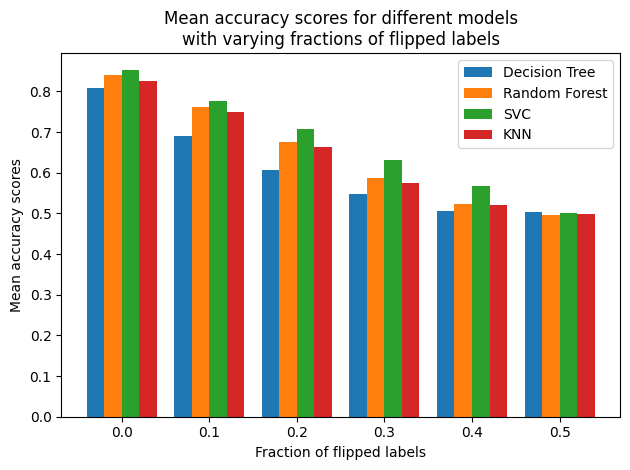

In [25]:
# Plot the results
tree_means = [np.mean(arr) for arr in tree_scores]
rf_means = [np.mean(arr) for arr in rf_scores]
svc_means = [np.mean(arr) for arr in svc_scores]
knn_means = [np.mean(arr) for arr in knn_scores]

x = np.arange(0, 0.6, 0.1)
width = 0.02

fig, ax = plt.subplots()
tree_bars = ax.bar(x - 1.5 * width, tree_means, width, label='Decision Tree')
rf_bars = ax.bar(x - 0.5 * width, rf_means, width, label='Random Forest')
svc_bars = ax.bar(x + 0.5 * width, svc_means, width, label='SVC')
knn_bars = ax.bar(x + 1.5 * width, knn_means, width, label='KNN')

ax.set_xlabel('Fraction of flipped labels')
ax.set_ylabel('Mean accuracy scores')
ax.set_xticks(x)
ax.legend()

plt.title('Mean accuracy scores for different models\nwith varying fractions of flipped labels')
plt.tight_layout()
plt.savefig('accuracy_scores.png', dpi=300)

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words

In [ ]:
def discovery_algorithm(datasets: list, threshold: float, shuffle: bool) -> list:
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """
    similar_datasets = []
    for i, dataset1 in enumerate(datasets):
        for j, dataset2 in enumerate(datasets):
            if i == j or i > j:
                continue
            intersection = pd.merge(dataset1, dataset2, how='inner', on=['first_name', 'last_names']).shape[0]
            union = pd.merge(dataset1, dataset2, how='outer', on=['first_name', 'last_names']).shape[0]
            similarity = intersection/union
            if similarity >= threshold:
                similar_datasets.append((i, j, similarity))
    
    if shuffle:
        pair1 = similar_datasets.pop()
        pair2 = similar_datasets.pop()
        similar_datasets.append((pair1[1], pair2[1], 1))
        similar_datasets.append((pair2[0], pair1[0], 1))
    return similar_datasets

In [ ]:
## Do some testing using different degrees of relations on the downstream task.
##

def read_data(file_name):
    df = pd.read_csv(file_name, na_values='?').iloc[: , 1:]
    if 'salary' in df.columns:
        df['salary'] = df['salary'].str.replace('.', '')
    return df

def merge_datasets(dataset_names, select_columns, remove_duplicate_names=False, pertubate=False):
    datasets = [read_data(name) for name in dataset_names]
    related_datasets = discovery_algorithm(datasets, 0.5, pertubate)

    inner_joins = []
    for i, j, similarity in related_datasets:
        if remove_duplicate_names:
            ds1 = datasets[i].drop_duplicates(["first_name", "last_names"])
            ds2 = datasets[j].drop_duplicates(["first_name", "last_names"])
        else:
            ds1 = datasets[i]
            ds2 = datasets[j]
        overlap = list(ds1.columns.str.lower().intersection(ds2.columns.str.lower()))
        merged_dataset = pd.merge(ds1, ds2, how='inner', on=overlap)
        inner_joins.append(merged_dataset)


    to_merge = inner_joins.copy()
    while len(to_merge) > 1:
        ds1 = to_merge.pop()
        ds2 = to_merge.pop()
        column_overlap = list(ds1.columns.str.lower().intersection(ds2.columns.str.lower()))
        merged_dataset = pd.merge(ds1, ds2, how='outer', on=column_overlap)
        to_merge.append(merged_dataset)

    merged = inner_joins + to_merge

    return [ds.drop(columns=['first_name', 'last_names']).drop_duplicates() for ds in merged]

dataset_names = ["adult_split/data_adult_0_1.csv", "adult_split/data_adult_0_2.csv", "adult_split/data_adult_1_1.csv", "adult_split/data_adult_1_2.csv", "adult_split/data_adult_2_1.csv", "adult_split/data_adult_2_2.csv"]
select_columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]

datasets_merged = merge_datasets(dataset_names, select_columns) 
print(datasets_merged[3].shape)
datasets_merged_no_duplicates = merge_datasets(dataset_names, select_columns, remove_duplicate_names=True)
print(datasets_merged_no_duplicates[3].shape)
datasets_merged_pertubated = merge_datasets(dataset_names, select_columns, pertubate=True)
print(datasets_merged_pertubated[3].shape)


(50165, 15)
(48307, 15)
(16729, 15)


### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [ ]:
def run_model(model, train_x, train_y, test_x, test_y):
    cats = [c for c in ['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country'] if c in train_x.columns.str.lower()]
    nums = [c for c in ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'] if c in train_x.columns.str.lower()]

    steps = [
        ('cat', OneHotEncoder(handle_unknown="ignore"), cats), # Maybe try one hot encoding.
        ('num', StandardScaler(), nums)      # Other normalizing for the numericals
    ]

    # Combine steps into a ColumnTransformer
    ct = ColumnTransformer(steps)

    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    pipeline.fit(train_x, train_y)      # Fits the model using the transformed data
    s = pipeline.score(test_x, test_y)  # Uses the standard scoring function of the model
    return s


In [ ]:
## Do some testing on performing various degrees of incorrect data discovery.
##
le = LabelEncoder()

test_data = pd.read_csv("adult.csv", na_values='?').dropna()
test_data['salary'] = test_data['salary'].apply(lambda x: x.strip('.'))
test_data = test_data.sample(frac=0.3).reset_index(drop=True)

def eval_datasets(datasets):
    results = []
    for data in datasets:
        data.dropna(inplace=True)
        if data.shape[0] < 5:
            results.append([0, 0, 0, 0])
            continue
        data['salary'] = data['salary'].apply(lambda x: x.strip('.')) # Remove trailing dot

        train_x = data.drop(columns=['salary'])
        train_y = le.fit_transform(data['salary']).astype(int)
        test_x = test_data[train_x.columns.str.lower()]
        test_y = le.fit_transform(test_data['salary']).astype(int)

        nn = run_model(KNeighborsClassifier(n_neighbors=min(train_x.shape[0],5)), train_x, train_y, test_x, test_y)
        rf = run_model(RandomForestClassifier(), train_x, train_y, test_x, test_y)
        svc = run_model(SVC(), train_x, train_y, test_x, test_y)
        rt = run_model(DecisionTreeClassifier(), train_x, train_y, test_x, test_y)
        results.append([nn, rf, svc, rt])
    return results

merged_with_duplicates = eval_datasets(datasets_merged)
merged_without_duplicates = eval_datasets(datasets_merged_no_duplicates)
merged_random = eval_datasets(datasets_merged_pertubated)




[[0.840569027788015, 0.8999778875211911, 0.8553843885899609, 0.8629763396476745], [0, 0, 0, 0], [0.662710989901968, 0.7367140856490012, 0.6698606913835041, 0.5643841674651728], [0.840569027788015, 0.8991670966315324, 0.8554580968526572, 0.8623866735461045]]


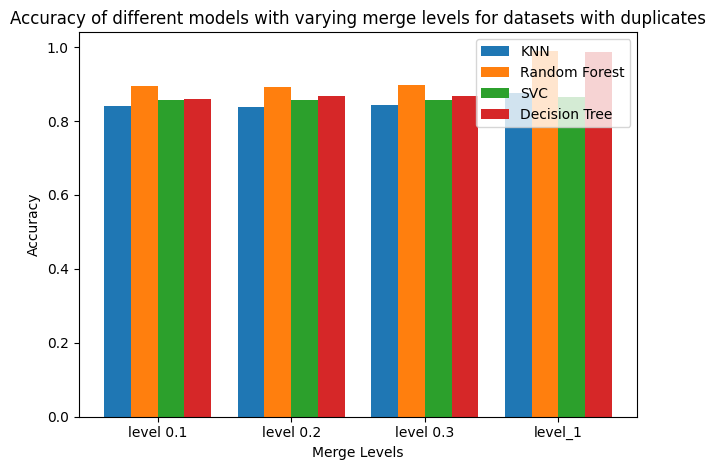

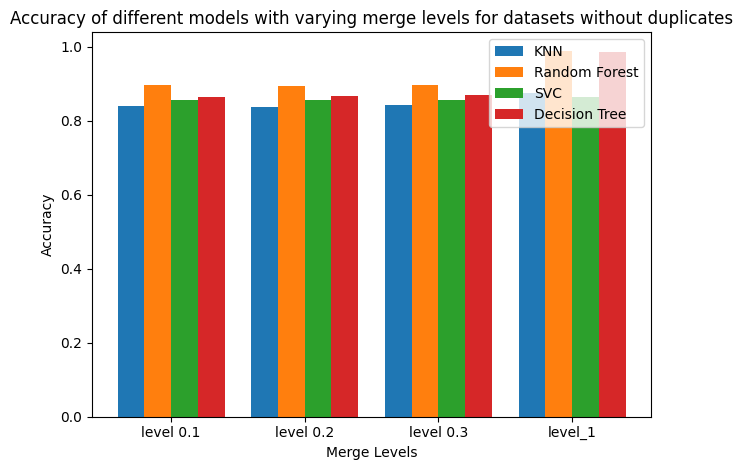

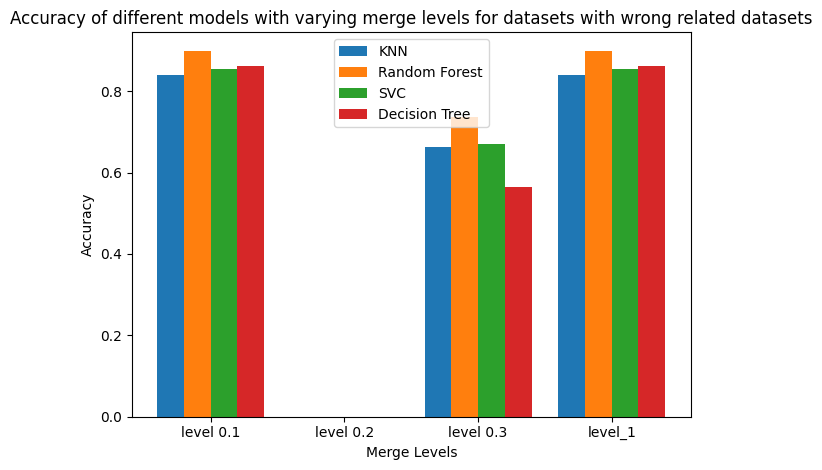

In [ ]:
import matplotlib.pyplot as plt
# # Plot the results


labels = ['KNN', 'Random Forest', 'SVC', 'Decision Tree']
group_labels = ["level 0.1", "level 0.2", "level 0.3", "level_1"]

# Convert data into NumPy array for easy manipulation
data = np.array(merged_with_duplicates)

# Number of groups and number of bars per group
num_groups = data.shape[0]
num_bars = data.shape[1]

bar_width = 0.2

indices = np.arange(num_groups)

fig, ax = plt.subplots()

for i in range(num_bars):
    ax.bar(indices + i * bar_width, data[:, i], bar_width, label=labels[i])

ax.set_xlabel('Merge Levels')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of different models with varying merge levels for datasets with duplicates')
ax.set_xticks(indices + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(group_labels)
ax.legend()

plt.tight_layout()
plt.show()

# Convert data into NumPy array for easy manipulation
data = np.array(merged_without_duplicates)

# Number of groups and number of bars per group
num_groups = data.shape[0]
num_bars = data.shape[1]

bar_width = 0.2

indices = np.arange(num_groups)

fig, ax = plt.subplots()

for i in range(num_bars):
    ax.bar(indices + i * bar_width, data[:, i], bar_width, label=labels[i])

ax.set_xlabel('Merge Levels')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of different models with varying merge levels for datasets without duplicates')
ax.set_xticks(indices + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(group_labels)
ax.legend()

plt.tight_layout()
plt.show()

# Convert data into NumPy array for easy manipulation
data = np.array(merged_random)

# Number of groups and number of bars per group
num_groups = data.shape[0]
num_bars = data.shape[1]

bar_width = 0.2

indices = np.arange(num_groups)

fig, ax = plt.subplots()

for i in range(num_bars):
    ax.bar(indices + i * bar_width, data[:, i], bar_width, label=labels[i])

ax.set_xlabel('Merge Levels')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of different models with varying merge levels for datasets with wrong related datasets')
ax.set_xticks(indices + bar_width * (num_bars - 1) / 2)
ax.set_xticklabels(group_labels)
ax.legend()

plt.tight_layout()
plt.show()